In [309]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [310]:
#cell for troubleshooting/Inputting the Week_Nums
week_nums = [190601,190608,190615, 190622]

#2019 [190601,190608,190615, 190622]
#2020 [190530,190606,190613, 190620]

In [311]:
def clean(week_nums):
    '''
    Takes in a list of weeks, returns a dataframe with the CSV's combined and time 
    
    ~~~~
    Parameters
    ----
    week_nums : TYPE = list (int)

    Returns
    ----
    dfs : TYPE = dataframe
    
    '''	
    dfs = []
    for week_num in week_nums: #Fetch data from MTA site for matching weeks
        url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
        file_url = url.format(week_num)
        names = ['c_a', 'unit', 'scp', 'station', 'linename', 'division', 
                 'date', 'time', 'desc', 'entries', 'exits']
        df = pd.read_csv(file_url, names=names, parse_dates=[['date','time']], 
                         keep_date_col=True, skiprows=1)
        df['date'] = pd.to_datetime(df['date'])
        df['day_of_week'] = df['date_time'].dt.day_name()
        df = df[(~df['c_a'].str.contains('PTH') & 
                 ~df['desc'].str.contains('RECOVR') & 
                 df.time.astype(str).str.contains('00:00'))]
        df = df[['station', 'unit', 'c_a', 'scp', 'date_time', 'date', 'day_of_week', 'time', 
                'desc', 'entries', 'exits']]
        #delete duplicates -> could be done after dataframe creation instead of in this loop
        df.sort_values(['c_a', 'unit', 'scp', 'station', 'date_time'], inplace=True, ascending=False)
        df.drop_duplicates(subset=['c_a', 'unit', 'scp', 'station', 'date_time'], inplace=True)
        dfs.append(df)
        #For troubleshooting: print(week_num)
    return pd.concat(dfs)


In [312]:
def get_counts_entry(row, max_counter):
    '''
    When called, takes in a row number and a max counter value and applies a test to see if the counter makes sense, then returns the delta between entries.
    
    ~~~~
    Parameters
    ----
    row : TYPE = int (row number in a dataframe)
    max_counter : TYPE = int

    Returns
    ----
    counter : TYPE = int
    
    '''
    counter = row["entries"] - row["prev_entries"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["entries"], row["prev_entries"])
        counter = min(row["entries"], row["prev_entries"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    if row["date_time"] - row["prev_datetime"] > timecop:
        return 0
    return counter

def get_counts_exit(row, max_counter):
    '''
    When called, takes in a row number and a max counter value and applies a test to see if the counter makes sense, then returns the delta between exits.
    
    ~~~~
    Parameters
    ----
    row : TYPE = int (row number in a dataframe)
    max_counter : TYPE = int

    Returns
    ----
    counter : TYPE = int
    
    '''
    counter = row["exits"] - row["prev_exits"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["exits"], row["prev_exits"])
        counter = min(row["exits"], row["prev_exits"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    if row["date_time"] - row["prev_datetime"] > timecop:
        return 0
    return counter


In [313]:
def turnstile(week_nums):
    '''
    Main function.
    Takes in a list of weeks, returns a dataframe with to be plotted with calculations done. Calls other functions.
    
    ~~~~
    Parameters
    ----
    week_nums : TYPE = list (int)

    Returns
    ----
    unit_hourly : TYPE = dataframe
    
    '''	
    #get data from web
    turnstiles_df = clean(week_nums)
    
    #add column specifying the prior block of time to find the change in total entries / exits
    '''
    This code creates groups based on SCP (physical turnstile lanes).
    '''
   
    turnstiles_block = (turnstiles_df
                        .groupby(["c_a", "unit", "scp", "station", "date_time", "exits"],as_index=False).entries.first())
    turnstiles_block[["prev_datetime", "prev_entries", "prev_exits"]] = (turnstiles_block
                                                                         .groupby(["c_a", "unit", "scp", "station"])["date_time", "entries", "exits"]
                                                                         .apply(lambda grp: grp.shift(1)))

    turnstiles_block.dropna(subset=["prev_datetime"], axis=0, inplace=True)
    #filter outlier exit and entry counts
    '''
    It is thought that it takes a minimum of 5 seconds to go through a turnstile. This means 2880 theoretical max input from an SCP in a 4 hour period. Increasing this by a factor of 5 gives us 14400, or about 15000
    '''
    timecop = (pd.to_datetime(140, unit='d')-pd.to_datetime(139, unit='d')) #timecop, enforcing temporal violations.
    
    #turnstiles_block['delta_entries'] = turnstiles_block.apply(get_counts_entry, axis=1, max_counter=15000)
    #Above line removed for performance reasons.
    #15000 max_counter value based on an order of magnitude larger than the highest possible values for SCP.
    turnstiles_block['delta_exits'] = turnstiles_block.apply(get_counts_exit, axis=1, max_counter=15000)

    #group turnstiles by time block, total
    '''
    This code sums turnstiles into Units (Remote units), or physical station locations based on billing. It keeps different names of stations still separate.
    '''
    unit_hourly = (turnstiles_block.groupby(['station','unit','date_time'])['delta_exits'].sum().reset_index())
    #unit_hourly = (turnstiles_block.groupby(['station','unit','date_time'])['delta_exits','delta_entries'].sum().reset_index())
    
    return unit_hourly


<ipython-input-313-7e1eab3aea15>:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_block[["prev_datetime", "prev_entries", "prev_exits"]] = (turnstiles_block


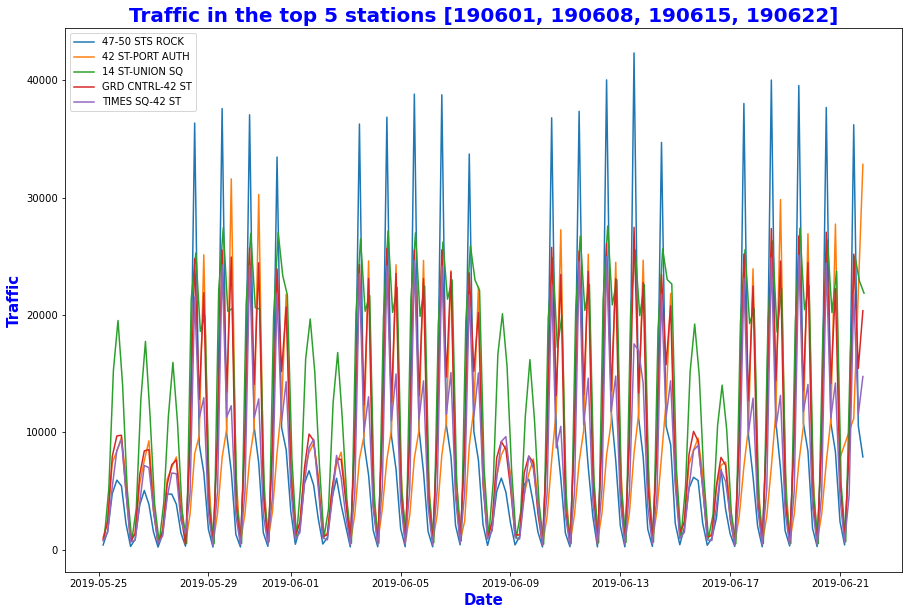

In [314]:
#Call other functions = Use this to create the dataframe to plot
unit_hourly = turnstile(week_nums)
#For troubleshooting:Create copy of turnstile so that we have backup dataframe
#unit_copy = unit_hourly.copy()

#Dataframe that sums exit/entry counts count by station / time blocks overall (even with stations that have 2 different names)
top = unit_hourly.groupby(['unit', 'date_time'])['delta_exits'].sum().reset_index()
#unit_hourly.groupby(['unit', 'date_time'])['delta_exits','delta_entries'].sum().reset_index()

#head length variable-> visually assess list til 10 uniques
top10 = (top.sort_values(by=['delta_exits'],ascending=False)
        .unit.head(100))

#Selecting top 10/5 units.
top10units = top10.unique()[:10]
top5units = top10.unique()[:5]

#creating a dictionary of unit and names of stations
unit_list = (unit_hourly.sort_values(by=['date_time'],ascending=False).unit).unique()
name_list = {}
for unit in unit_list:
    mask = (unit_hourly['unit'] == unit)
    name_prog = unit_hourly[mask]
    s = name_prog['station'].value_counts().idxmax()
    name = {unit : s}
    name_list.update(name)
    
    
plt.figure(figsize=[15,10])
for i in top5units: 
    mask = (top['unit'] == i)
    top5_df = top[mask]
    plt.plot(top5_df.date_time, top5_df.delta_exits, label = name_list[top5_df.unit.iloc[0]]) #Only change name of Unit to the corresponding station when graphing, and nowhere else to prevent name conflicts and unit doubling.
plt.legend()

plt.title('Traffic in the top 5 stations {}'.format(week_nums), fontsize=20, weight='bold',color='b')
plt.xlabel('Date', fontsize=15, weight='bold',color='b')
plt.ylabel('Traffic', fontsize=15, weight='bold',color='b')
plt.savefig('top5 stations traffic.svg')

#Depreciated Code
#.replace(name_list , inplace=True) #Warning! edits the original dataframe
#top.replace(name_list , inplace=True)

#fix up the lists made with units earlier
#top10units = [name_list.get(item, item) for item in top10units]
#top5units = [name_list.get(item, item) for item in top5units]

